In [14]:
scores = '../emap/all_genes/ko_scores.tsv'
conditions = '../emap/all_genes/conditions.tsv'

In [15]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sns.set_style('white')

In [16]:
import numpy as np
import pandas as pd
import fastcluster as fst

In [17]:
m = pd.read_table(scores)

In [18]:
strains = set(m['strain'])

In [19]:
m.set_index(['strain', 'condition'], inplace=True)
m.sort_index(inplace=True)

In [20]:
ctable = pd.read_table(conditions, index_col=0)
correct = ctable['corrected_condition_tag'].dropna().to_dict()
ctable = ctable['condition'].dropna().to_dict()

In [21]:
p = m.reset_index().pivot_table(index=['strain', 'gene'], columns='condition', values='score')

In [22]:
p.rename(columns={x: ctable.get(correct.get(x.split('-')[1].lower(),
                                            x.split('-')[1].lower()),
                                correct.get(x.split('-')[1].lower(),
                                            x.split('-')[1].lower())) +
                     ' (' + x.split('-')[0] + ')'
                  for x in p.columns},
         inplace=True)

In [23]:
c = p.copy(deep=True)
c[np.isnan(c)] = 0.
rl = fst.linkage(c, method='average')
cl = fst.linkage(c.T, method='average')
cmap = plt.get_cmap('vlag')
cmap.set_bad('green')

In [24]:
cstrains = {x: c for x, c in zip(strains, ['red', 'blue', 'green', 'black'])}

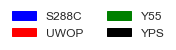

In [25]:
plt.figure(figsize=(2, 0.5))

handles = []
for k, v in sorted(cstrains.items(), key=lambda x: x[0]):
    handles.append(patches.Patch(color=v, label=k))

plt.legend(handles=handles, ncol=int(len(handles)/2),
           loc='center')
plt.yticks([])
plt.xticks([])
sns.despine(left=True,
            bottom=True)

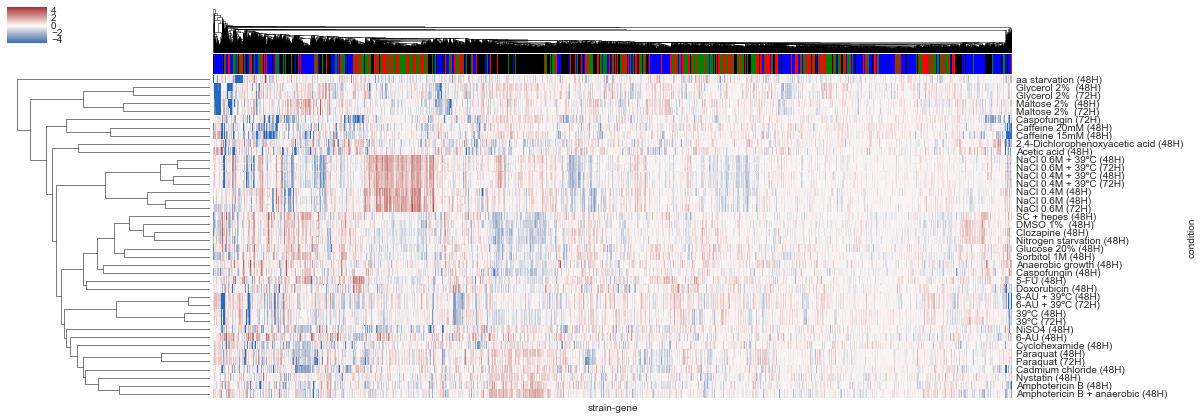

In [26]:
mclust = sns.clustermap(p.T,
                        cmap=cmap,
                        center=0,
                        vmax=5,
                        vmin=-5,
                        xticklabels=False,
                        yticklabels=True,
                        row_linkage=cl,
                        col_linkage=rl,
                        figsize=(18, 7),
                        col_colors=[cstrains[x[0]]
                                    for x in p.index]);

In [27]:
genes = {x[1] for x in p.index}

In [28]:
m = m.reset_index().set_index(['gene', 'strain'])
m.sort_index(inplace=True)
q = m['qvalue']
s = q[q < 0.05]

In [29]:
ps = {x: p.loc[x]
      for x in strains}

In [30]:
res = []
for g in genes:
    t = p.loc[(slice(None), g), ].T.corr()
    cmean = t.values[np.triu_indices_from(t.values, 1)].mean()
    scount = (s.loc[g].groupby('strain').count() / q.loc[g].groupby('strain').count()).dropna().shape[0]
    mphen = s.loc[g].shape[0] / q.loc[g].shape[0]
    res.append((g, cmean, scount, mphen))
r = pd.DataFrame(res,
                 columns=['gene', 'corr', 'sphenos', 'mphenos'])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice.
/home/mgalactus/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
res = []
for g in genes:
    t = pd.DataFrame([x.sample(1).iloc[0] for x in ps.values()]).T.corr()
    cmean = t.values[np.triu_indices_from(t.values, 1)].mean()
    res.append((g, cmean))
r1 = pd.DataFrame(res,
                 columns=['gene', 'corr'])

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


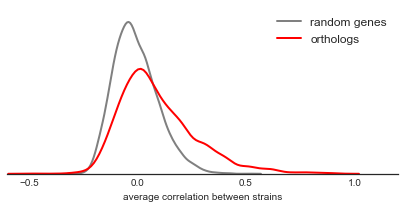

In [32]:
plt.figure(figsize=(7, 3))

sns.kdeplot(r1['corr'],
            label='random genes',
            color='grey',
            lw=2)
sns.kdeplot(r['corr'],
            label='orthologs',
            color='r',
            lw=2)

plt.xlabel('average correlation between strains')
plt.yticks([])
sns.despine(left=True);

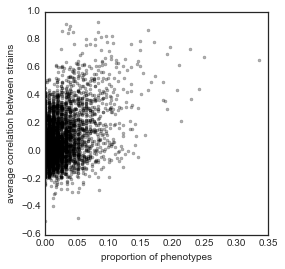

In [33]:
plt.figure(figsize=(4, 4))

plt.plot(r['mphenos'],
         r['corr'],
         'k.',
         alpha=0.3)

plt.xlabel('proportion of phenotypes')
plt.ylabel('average correlation between strains');

<h5><a href="javascript:toggle()" target="_self">toggle source code</a></h5>